# Using manipulated data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tick
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
import os
from collections import defaultdict
from scipy.optimize import minimize_scalar

In [3]:
# Set global font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'Georgia']
plt.rcParams['font.size'] = 14

In [4]:
def simulate_all(baselines, adjacency, decay, end_time, seed = 0):
    stat = {}
    #adjacency = np.array([[0.64149858]]) #alpha
    #decay = 1205.6028014007004 # beta
    #baselines = np.array([0.38069134]) #lambda
    stat["alpha"] = adjacency[0] * decay
    stat["beta"] =  decay
    stat["lam"] = baselines[0]
    
    
    hw = SimuHawkesExpKernels(adjacency, decay, baseline=baselines, seed=seed,verbose=False)
    hw.track_intensity(0.1)
    hw.end_time = end_time
    hw.simulate()

    ts = hw.timestamps[0] #ts
    # Convert ts_rescaled to datetime
    start_time = pd.Timestamp('2012-06-21 00:00:00') 
    datetime_array = start_time + pd.to_timedelta(ts, unit='s')

    # Create a DataFrame
    df = pd.DataFrame({
        'datetime': datetime_array,
        'time': ts
    })
    return df

def nth_order_markov_chain(df, n):
    # Initialize transition counts
    transition_counts = defaultdict(lambda: defaultdict(int))
    
    # Count transitions
    for i in range(len(df) - n):
        current_states = tuple(df.iloc[i:i+n]['state'])
        next_state = df.iloc[i+n]['state']
        transition_counts[current_states][next_state] += 1

    # Normalize to get transition probabilities
    transition_probs = defaultdict(dict)
    for current_states, next_states_counts in transition_counts.items():
        total_transitions = sum(next_states_counts.values())
        for next_state, count in next_states_counts.items():
            transition_probs[current_states][next_state] = count / total_transitions

    return transition_probs
def simulate_markov_chain(transition_probs, initial_state, num_steps, dstate, seed = 0):
    """
    Simulate an n-th order Markov chain.
    
    Parameters:
    - transition_probs: Transition probabilities (dict of dicts).
    - initial_state: Initial sequence of states (tuple).
    - num_steps: Number of steps to simulate.
    
    Returns:
    - List of simulated states.
    """
    if seed is not None:
        np.random.seed(seed)  # Set the seed if provided
    n = len(initial_state)
    current_state = initial_state
    simulated_states = list(current_state)
    
    for _ in range(num_steps):
        next_states = transition_probs.get(current_state)
        if not next_states:
            # If current state is not in transition_probs, break
            break
        next_state = np.random.choice(list(next_states.keys()), p=list(next_states.values()))
        simulated_states.append(next_state)
        current_state = tuple(simulated_states[-n:])
    state_to_value_dict = dstate['state_value'].to_dict()
    seq_values = list(map(state_to_value_dict.get, simulated_states))
    #df["mid_price2"] = seq_values
    return seq_values, simulated_states
    #return df

## Read data

In [5]:
stock = 'AMZN'
lob_level = 1
p = 'lobdataread'
msgfile = os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_message_{lob_level}.csv')
obfile =  os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_orderbook_{lob_level}.csv')
df1=pd.read_csv(msgfile, sep=',', header=None, 
        names=['time', 'type', 'ord_id', 'size', 'price', 'dir'],
        dtype={'time':np.float64, 'type':np.int32, 'ord_id':np.int32, 
               'size':np.int64, 'price':np.int64, 'dir':np.int32})

df2=pd.read_csv(obfile, sep=',', header=None, 
        names=['ask_prc_L1', 'ask_sz_L1', 'bid_prc_L1', 'bid_sz_L1'],
        dtype={'ask_prc_L1':np.float64, 'ask_sz_L1':np.int64, 'bid_prc_L1':np.float64, 'bid_sz_L1':np.int64})

df3 = pd.concat([df1, df2], axis=1)
df3 = df3.drop_duplicates(subset='time', keep='first')
df3['mid_price'] = (df3['ask_prc_L1'] + df3['bid_prc_L1'])/2
df3['datetime'] = pd.to_timedelta(df3['time'], unit='s') + pd.Timestamp("2012-06-21")
df3 = df3[(df3['datetime'].dt.time >= pd.Timestamp('2012-06-21 09:46:00').time()) & 
                 (df3['datetime'].dt.time <= pd.Timestamp('2012-06-21 15:44:00').time())]

In [6]:
df = df3[['time', 'datetime', 'mid_price']].copy()
df['mid_price'] = df['mid_price']/10000 
df.loc[:, 'mid_price'] = df['mid_price'] - df['mid_price'].iloc[0]
df.loc[:, 'time'] = df['time'] - df['time'].iloc[0]
df.reset_index(drop=True, inplace=True)
df['mid_diff'] = df['mid_price'].diff()
# Replace NaN with 0 at the beginning
df['mid_diff'].fillna(0, inplace=True)
threshold = 1e-6
df = df[df['mid_diff'].abs() >= threshold]
df.reset_index(drop=True, inplace=True)

In [7]:
df.head(2)

,time,datetime,mid_price,mid_diff
0,3.364486,2012-06-21 09:46:05.948977122,-0.015,-0.015
1,3.364625,2012-06-21 09:46:05.949116138,-0.020,-0.005


In [8]:
n_state = [3, 3]
n_state_neg = n_state[0]
n_state_pos = n_state[1]
n_state_tot = sum(n_state)

# Split data into positive and negative
df_positive = df[df['mid_diff'] >= 0]
df_negative = df[df['mid_diff'] < 0]


# Calculate quantiles for positive and negative data
quantiles_positive = df_positive['mid_diff'].quantile(list(np.linspace(0, 1, n_state_pos + 1 )[1:-1])).tolist()
quantiles_negative = df_negative['mid_diff'].quantile(list(np.linspace(0, 1, n_state_neg + 1 )[1:-1])).tolist()

# Remove duplicates
quantiles_positive = sorted(list(set(quantiles_positive)))
quantiles_negative = sorted(list(set(quantiles_negative)))

# Calculate state values a(i) for positive data
a_positive = []
a_positive.append(df_positive[(df_positive['mid_diff'] <= quantiles_positive[0])]['mid_diff'].mean())
for i in range(len(quantiles_positive) - 1):
    a_positive.append(df_positive[(df_positive['mid_diff'] > quantiles_positive[i]) & 
                                  (df_positive['mid_diff'] <= quantiles_positive[i+1])]['mid_diff'].mean())
a_positive.append(df_positive[(df_positive['mid_diff'] > quantiles_positive[-1])]['mid_diff'].mean())


# Calculate state values a(i) for negative data
a_negative = []
a_negative.append(df_negative[(df_negative['mid_diff'] < quantiles_negative[0])]['mid_diff'].mean())
for i in range(len(quantiles_negative) - 1):
    a_negative.append(df_negative[(df_negative['mid_diff'] >= quantiles_negative[i]) & 
                                  (df_negative['mid_diff'] < quantiles_negative[i+1])]['mid_diff'].mean())
a_negative.append(df_negative[(df_negative['mid_diff'] >= quantiles_negative[-1])]['mid_diff'].mean())


In [9]:
# Assign states to price changes
df['state'] = np.nan

# Assign states for negative data
df.loc[df['mid_diff'] < quantiles_negative[0], 'state'] = 0
df.loc[df['mid_diff'] < quantiles_negative[0], 'state_value'] = a_negative[0]
for i in range(1, len(quantiles_negative)):
    df.loc[(df['mid_diff'] >= quantiles_negative[i-1]) & (df['mid_diff'] < quantiles_negative[i]), 'state'] = i
    df.loc[(df['mid_diff'] >= quantiles_negative[i-1]) & (df['mid_diff'] < quantiles_negative[i]), 'state_value'] = a_negative[i]
df.loc[(df['mid_diff'] >= quantiles_negative[-1])  & (df['mid_diff'] < 0), 'state'] = len(quantiles_negative)
df.loc[(df['mid_diff'] >= quantiles_negative[-1])  & (df['mid_diff'] < 0), 'state_value'] = a_negative[-1]
    
    
start_state_pos = len(a_negative) 
df.loc[(df['mid_diff'] <= quantiles_positive[0]) & (df['mid_diff'] >= 0) , 'state'] = start_state_pos 
df.loc[(df['mid_diff'] <= quantiles_positive[0]) & (df['mid_diff'] >= 0), 'state_value'] = a_positive[0]
for i in range(1, len(quantiles_positive)):
    df.loc[(df['mid_diff'] > quantiles_positive[i - 1]) & (df['mid_diff'] <= quantiles_positive[i]), 'state'] = start_state_pos + i
    df.loc[(df['mid_diff'] > quantiles_positive[i - 1]) & (df['mid_diff'] <= quantiles_positive[i]), 'state_value'] = a_positive[i]
df.loc[df['mid_diff'] > quantiles_positive[-1], 'state'] = start_state_pos + len(quantiles_positive)
df.loc[df['mid_diff'] > quantiles_positive[-1], 'state_value'] =  a_positive[-1]
df['state'] = df['state'].astype(int)

In [10]:
df.head(2)

,time,datetime,mid_price,mid_diff,state,state_value
0,3.364486,2012-06-21 09:46:05.948977122,-0.015,-0.015,0,-0.028456
1,3.364625,2012-06-21 09:46:05.949116138,-0.020,-0.005,2,-0.005000


In [11]:
df.isnull().any()

time           False
datetime       False
mid_price      False
mid_diff       False
state          False
state_value    False
dtype: bool

In [12]:
df = df[['time', 'datetime', 'mid_diff', 'mid_price', 'state', 'state_value']]

In [13]:
df.head(2)

,time,datetime,mid_diff,mid_price,state,state_value
0,3.364486,2012-06-21 09:46:05.948977122,-0.015,-0.015,0,-0.028456
1,3.364625,2012-06-21 09:46:05.949116138,-0.005,-0.020,2,-0.005000


In [14]:
%matplotlib inline
#df.mid_price.plot()

## Hawkes process

In [15]:
timestamps_list = [df['time'].values]
# Define a function to compute the negative hawkes score for a given decay
def negative_hawkes_score(decay):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000, tol=1e-10)
    hawkes_learner.fit(timestamps_list)
    return -hawkes_learner.score()

# Use minimize_scalar to find the decay that minimizes the negative hawkes score
result = minimize_scalar(negative_hawkes_score, bounds=(500, 5000), method='bounded')

# Extract the optimal decay and the maximum hawkes score from the result
optimal_decay = result.x
max_score = -result.fun

print("Optimal Decay Value:", optimal_decay)
print("Maximum Hawkes Score:", max_score)
best_hawkes = HawkesExpKern(optimal_decay, verbose=False, max_iter=10000, tol=1e-10)
best_hawkes.fit(timestamps_list)
best_decay = optimal_decay
best_score = best_hawkes.score()

Optimal Decay Value: 1205.7552168460784
Maximum Hawkes Score: 692.9856742937149


In [16]:
#best_hawkes = hw
#best_decay = decay

In [17]:
print(f'n = {best_hawkes.n_nodes}',
      f'mu = {best_hawkes.baseline}', 
      f'alpha = {best_hawkes.adjacency}', '\n'
      f'beta = {best_decay}, alpha_p = {best_hawkes.adjacency * best_decay}')

n = 1 mu = [0.3808394] alpha = [[0.64147762]] 
beta = 1205.7552168460784, alpha_p = [[773.46499037]]


## Markov Process

## Read data

In [18]:
dstate = df.drop_duplicates(subset='state')[['state', 'state_value']].sort_values(by='state').set_index('state')

## Transition probability

In [19]:
transition_probs = nth_order_markov_chain(df, n = 4)

In [20]:
dd = simulate_all(best_hawkes.baseline, best_hawkes.adjacency, best_decay, 21469.625623, 0)
#dd.head(-1)

In [21]:
def get_stat_real(df, col = "mid_price", a_star = 1, seed = 0):
    df_ = df.copy()
    df_ = df_.set_index('datetime')
    windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
    std_values = {}
    for window in windows:
        window = str(window) + 'S'
        mid_price =  df_[col].resample(window).apply(lambda x: x[-1] - x[0])
        jump = df_[col].resample(window).size() * a_star
        p_result = mid_price - jump
        std_value = p_result.dropna().std()
        std_values[window] = std_value

    return std_values

def get_stat_sim(df, col, transition_probs, initial_state, dstate, a_star = 1, seed = 0):
    df_ = df.copy()
    num_steps = len(df_)
    s, _ = simulate_markov_chain(transition_probs, initial_state, num_steps - len(initial_state), dstate, seed)
    df_[col] = np.cumsum(s)
    std_values_sim = get_stat_real(df_, col = col, a_star = a_star, seed = seed)
    return std_values_sim


In [22]:
#fig, ax = plt.subplots(1,1, figsize = (30, 5))
#ax.plot(s3['state'].resample('1S'))#, s30[0:10]['state'])


In [23]:
np.random.seed(1000)
sd = np.random.choice(20000, 20)

In [24]:
stdv = []
stds = []
for s in sd:
    initial_state = (0, 2, 3, 4)  # For a 2nd order Markov chain
    a_star = -5.468532764853179e-05
    sv = get_stat_real(df, col = "mid_price", a_star = a_star, seed = s)
    dg = simulate_all(best_hawkes.baseline, best_hawkes.adjacency, best_decay, 21469.625623, 0)
    svsim = get_stat_sim(dg, "mid_price", transition_probs, initial_state, dstate, a_star, seed = s)
    #sv, svsim, _, _ =  get_stat(df, transition_probs, initial_state, dstate, a_star, s)
    stdv.append(sv)
    stds.append(svsim)

In [25]:
def get_avg(data):
    sums = {key: 0 for key in data[0].keys()}
    for d in data:
        for key, value in d.items():
            sums[key] += value
    averages = {key: value / len(data) for key, value in sums.items()}
    return averages

In [26]:
std_values = get_avg(stdv)
std_values_sim = get_avg(stds)

In [27]:
%matplotlib inline
#import matplotlib
#fig, ax = plt.subplots(1,1, figsize  = (25,5))
#ax.plot(df.datetime, df.mid_price)
#ax.plot(df.datetime, df.mid_price2)
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
#ax.set_xlim([0, 21400])
#ax.set_ylim([-5, 2])

In [28]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
def mycurvefit(std_values, std_values_theory):
    x = [int(key[:-1]) for key in std_values.keys()]
    y = list(std_values.values())

    def func(x, a, b):
        return a * np.sqrt(x) + b
    params, covariance = curve_fit(func, x, y)
    a, b = params
    y_pred = func(x, a, b)
    y_true = list(std_values_theory.values())
    #y_signal = y
    return  y_pred, y_true, a, b
y_pred, y_true, a, b = mycurvefit(std_values, std_values_sim)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(rmse)
print("& ".join(map(str, [a, b, rmse])))

0.030943179814477355
0.015132399004827705& 0.0912273370232847& 0.030943179814477355


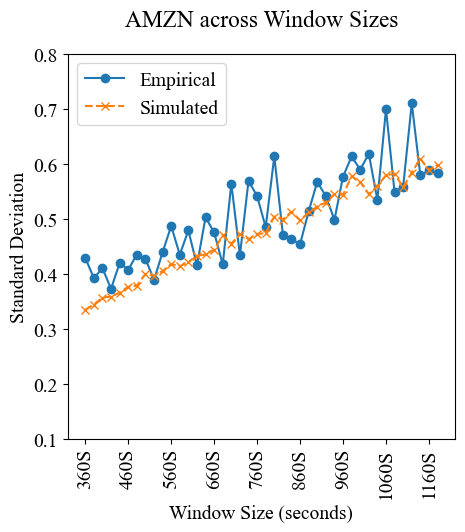

In [30]:
# 10 Plotting the results
plt.figure(figsize=(5, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_sim.keys()), list(std_values_sim.values()), marker='x', linestyle='--', label='Simulated')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('AMZN across Window Sizes', y= 1.05)
plt.legend()
n = 5
keys = list(std_values.keys())
plt.xticks(keys[::n], keys[::n], rotation=90)
plt.ylim([.1, 0.8])
#plt.grid(True)
plt.savefig("./pics/amzn_std_n_markov.png", dpi=300, bbox_inches='tight')
plt.show()